# Hudgkin Huxley (Subcritical-Hopf) Bifurcation Graph Explainned from scratch

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil


In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
from matplotlib.patches import Polygon
def zoomingPoly(ax1, roi, ax2, color='red', linewidth=2, dy=0,roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
#     ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    ax1.add_patch(Polygon([(roi[0],roi[2]),(roi[1],roi[2]+dy),(roi[1],roi[3]+dy),(roi[0],roi[3]),(roi[0],roi[2])], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]


In [6]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

In [8]:
# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

In [9]:
import re

def get_floquet_mults_from_fortDot9():
    ##### Writes the floquet multipliers calculated in AUTO in a directory
    ### After running a continuation, extract multipliers from file fort.9
    ## and store them in a directory
    ## Make sure the file exists....
    # This was done fast.. maybe can be simplified with split....
    result = {}
    result['PT']={}
    mult_regex0 = r"""-?\d+\s+(\d+)\s+Multipliers:\s+Stable:\s+(\d+)"""
    mult_regex1 = r"""-?\d+\s+(\d+)\s+Multiplier\s+(\d+)\s+(\S+)"""
    with open('fort.9', 'r') as f:
        for line in f:
            if 'Multipliers' in line:
                line_match = re.search(mult_regex0, line)
                if line_match is None:
                    continue
                if line_match.group(1) is not None:
                    result['PT'][line_match.group(1)] = {}
                    result['PT'][line_match.group(1)]["stable"] = int(line_match.group(2))
                    result['PT'][line_match.group(1)]['Floquet_Multipliers']=[]
            else:
                line_match = re.search(mult_regex1, line)
                if line_match is None:
                    continue
                if line_match.group(1) is not None:
                    result['PT'][line_match.group(1)]['Floquet_Multipliers'].append(float(line_match.group(3)))
                    
    return result

In [10]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [11]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False,tight=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        if tight:
            ax.savefig(fig_name+'.png',dpi=rast, bbox_inches = 'tight',
    pad_inches = 0)
            fig.savefig(pdffig, format="pdf",dpi=rast, bbox_inches = 'tight',
    pad_inches = 0)
        else:
            ax.savefig(fig_name+'.png',dpi=rast)
            fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        if tight:
            ax.savefig(fig_name+'.png', bbox_inches = 'tight',
    pad_inches = 0)
            fig.savefig(pdffig, format="pdf", bbox_inches = 'tight',
    pad_inches = 0)

        else:
            ax.savefig(fig_name+'.png')
            fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

# Defining setup for the continuations

### Defining neuron model

In [12]:
## Loading neuron model (file in the cfg folder)
model_name='Hodgkin_Huxley'
### How is the applied current parameter called
strIapp='I_in'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Defining bifurcation parameters


In [13]:
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
I_app=-30.0
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app


In [14]:
### Using the function above to obtain the expressions from the model (needed to run AUTO)
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


# Running AUTO (to continue on the bifpar space)

### Continuing the ss forward to find the saddle node and the hopf bifurcations

In [15]:
import autoutils
import auto
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app
    r1_fwd= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
        UZSTOP= {})

## Making sure the original path is restored
os.chdir(cwd_nonTemp)
###### HEre we store the continuation in np arrays vectors
v_s_par=[strIapp]

v_s_var=[]
for i in range(len(unames)):
    v_s_var.append(unames[i+1])

m_res_par=[]
for i_s in v_s_par:
    m_res_par.append(r1_fwd[i_s])

m_res_statev=[]
for i_s in v_s_var:
        m_res_statev.append(r1_fwd[i_s])

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30.0, 11: 0}
For fix point continuation AUTO requires:
1=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_Hodgkin_Huxley.c -o autoOrbitSpike_Hodgkin_Huxley.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_Hodgkin_Huxley.o -o autoOrbitSpike_Hodgkin_Huxley.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_Hodgkin_Huxley ...

  BR    PT  TY  LAB      I_in        L2-NORM          v             n             m             h       
   1     1        2   4.26458E+00   2.94497E+00   2.87969E+00   3.62577E-01   7.38853E-02   4.93269E-01
   1   606  HB    3   9.77934E+00   5.37718E+00   5.34586E+00   4.01784E-01   9.72574E-02   4.06228E-01
   1     2        4   1.02563E+02   1.86701E+01   1.86571E+01   6.01541E-01   3.35449E-01   1.01657E-01
   1  5209  HB    5   1.54526E+02   2.19555E+01   2.19419

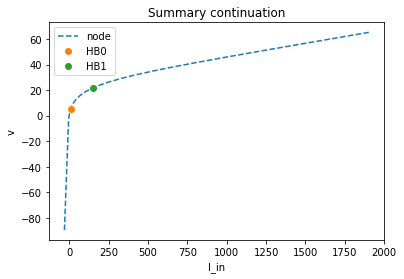

In [16]:
## Summary continuation..
plt.plot(m_res_par[0],m_res_statev[v_s_var=='v'],'--',label='node')
plt.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'o',label='HB0')
plt.plot(r1_fwd.getLabel('HB')[1][strIapp],r1_fwd.getLabel('HB')[1]['v'],'o',label='HB1')
plt.xlabel(strIapp)
plt.ylabel(v_s_var[v_s_var=='v'])
plt.title('Summary continuation')
plt.legend()

In [17]:
### Extracting current for initiation of regular spiking, and for depolarization block
s0HB = r1_fwd('HB')[0]
s1HB = r1_fwd('HB')[1]

### Continuing the hopf point backwards to find the limit cycle onset (period>>0).

In [18]:
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    r1_period0_b = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,   
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-3, DSMIN=-1e-3, DSMAX=-1e-2, NTST= 300,
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100})
    r1_period0_f = auto.run(s0HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=1e-3, DSMIN=1e-3, DSMAX=1e-2, NTST= 300,
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100})
    
    r1_period0=r1_period0_b+r1_period0_f
        
os.chdir(cwd_nonTemp)
############ Extracting info from AUTO object
#############################################################
##### Finding limit cycle onset (period>>0)
try:
    lc_onset = r1_period0.getLabel('LP')[0]
except:
    try:
        lc_onset = r1_period0.getLabel('UZ')[0]
    except:
        pass
    pass


###### HEre we extract the information AUTO calculated and store it in numpy arrays     
m_res_par_lc=[]
for i_s in v_s_par:
    m_res_par_lc.append(r1_period0[i_s])

m_res_statev_lc=[]
for i_s in v_s_var:
    m_res_statev_lc.append(r1_period0['MAX '+i_s])


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30.0, 11: 0}
For fix point continuation AUTO requires:
1=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_Hodgkin_Huxley.c -o autoOrbitSpike_Hodgkin_Huxley.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_Hodgkin_Huxley.o -o autoOrbitSpike_Hodgkin_Huxley.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_Hodgkin_Huxley ...

  BR    PT  TY  LAB      I_in        L2-NORM        MAX v         MAX n         MAX m         MAX h         period    
   5     3  BP   24   1.54526E+02   2.19555E+01   2.19443E+01   6.43256E-01   4.19733E-01   7.03610E-02   5.91124E+00
   5  3000       25   1.26220E+02   2.22553E+01   3.42328E+01   6.71635E-01   6.79362E-01   1.07895E-01   6.29256E+00
   5  6000       26   9.67785E+01   2.33574E+01   4.65172E+01   6.92015E-01   8.35789E-01   1.46117E-01   6.86188E+00
 

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Starting autoOrbitSpike_Hodgkin_Huxley ...

  BR    PT  TY  LAB      I_in        L2-NORM        MAX v         MAX n         MAX m         MAX h         period    
   3   594  LP   24   7.84625E+00   7.88947E+00   1.35530E+01   4.77401E-01   2.18311E-01   4.35904E-01   1.67138E+01
   3   847  LP   25   7.92169E+00   1.01526E+01   1.87350E+01   5.39089E-01   3.30119E-01   4.30485E-01   2.07073E+01
   3  2763  LP   26   6.26422E+00   2.14135E+01   9.14946E+01   7.46007E-01   9.85428E-01   4.96394E-01   1.98952E+01
   3  3000       27   6.40363E+00   2.27295E+01   9.43219E+01   7.50509E-01   9.87674E-01   4.96624E-01   1.85146E+01
   3  6000       28   3.10274E+01   2.70057E+01   8.36677E+01   7.37262E-01   9.77294E-01   3.22553E-01   1.00159E+01
   3  9000       29   6.03288E+01   2.55603E+01   6.64769E+01   7.17286E-01   9.43702E-01   2.21178E-01   8.02062E+00
   3  2001       30   8.97091E+01   2.37380E+01   5.00980E+01   6.96999E-01   8.64916E-01   1.57805E-01   7.03123E+00
   3  5001 

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


(5, 15)

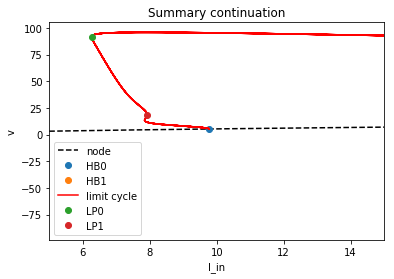

In [19]:
## Summary continuation..
plt.plot(m_res_par[0],m_res_statev[v_s_var=='v'],'--',color='k',label='node')
plt.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'o',label='HB0')
plt.plot(r1_fwd.getLabel('HB')[1][strIapp],r1_fwd.getLabel('HB')[1]['v'],'o',label='HB1')
## stable Limit cycle
plt.plot(m_res_par_lc[0],m_res_statev_lc[v_s_var=='v'],color='r',label='limit cycle')

plt.legend()

plt.plot(r1_period0.getLabel('LP')[0][strIapp],r1_period0.getLabel('LP')[0]['MAX v'],'o',label='LP0')
plt.plot(r1_period0.getLabel('LP')[1][strIapp],r1_period0.getLabel('LP')[1]['MAX v'],'o',label='LP1')
plt.xlabel(strIapp)
plt.ylabel(v_s_var[v_s_var=='v'])
plt.title('Summary continuation')

plt.legend()
plt.xlim([5,15])

In [20]:
### Extracting limit cycle onset
lc=r1_period0.getLabel('LP')[1]

# Finding phase planes for different I_apps

In [21]:
##############################################3
### Finding phase planes in the spiking and stable region
I_app=-30


## Applied currents for which we want to get the phase planes
t_I_app_specf=[lc[strIapp]-5,lc[strIapp]-1.0,lc[strIapp]-0.5,lc[strIapp]+0.5,lc[strIapp]+1,lc[strIapp]+5]
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
### Extracting inistates & expressions
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app   
    r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    
os.chdir(cwd_nonTemp)


s1HB = r1_fwd_sn_I_app_specf('HB')[0]
## Extracting all the steady states for the applied currents t_I_app_specf
ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')



initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 11: 0}
For fix point continuation AUTO requires:
1=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_Hodgkin_Huxley.c -o autoOrbitSpike_Hodgkin_Huxley.o


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_Hodgkin_Huxley.o -o autoOrbitSpike_Hodgkin_Huxley.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_Hodgkin_Huxley ...

  BR    PT  TY  LAB      I_in        L2-NORM          v             n             m             h       
   1  9845  UZ    2   2.92169E+00   2.19886E+00   2.10620E+00   3.50388E-01   6.76385E-02   5.21101E-01
   1     1        3   4.26439E+00   2.94487E+00   2.87959E+00   3.62575E-01   7.38845E-02   4.93273E-01
   1   298  UZ    4   6.92169E+00   4.22404E+00   4.18195E+00   3.83236E-01   8.55408E-02   4.46792E-01
   1   353  UZ    5   7.42169E+00   4.44024E+00   4.40065E+00   3.86717E-01   8.76458E-02   4.39081E-01
   1   462  UZ    6   8.42169E+00   4.85325E+00   4.81775E+00   3.93363E-01   9.17829E-02   4.24481E-01
   1   516  UZ    7   8.92169E+00   5.05084E+00   5.01703E+00   3.96540E-01   9.38173E-02   4.17561E-01
   1   608  HB    8 

In [22]:
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'],ISP=3, ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {strIapp: t_I_app_specf},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,strIapp: t_I_app_specf[0]-0.1})
    
    d_Floq_Mults_Iapp_Specf=get_floquet_mults_from_fortDot9()
    
    
    
os.chdir(cwd_nonTemp)
## Extracting all the steady states and limit cycle onsets  for the applied currents t_I_app_specf
lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 11: 0}
For fix point continuation AUTO requires:
1=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_Hodgkin_Huxley.c -o autoOrbitSpike_Hodgkin_Huxley.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_Hodgkin_Huxley.o -o autoOrbitSpike_Hodgkin_Huxley.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_Hodgkin_Huxley ...

  BR    PT  TY  LAB      I_in        L2-NORM        MAX v         MAX n         MAX m         MAX h         period    
   8     3  BP   30   9.77931E+00   5.37719E+00   5.36061E+00   4.01859E-01   9.74117E-02   4.06339E-01   1.07179E+01
   8    28  UZ   31   8.92169E+00   5.69665E+00   8.25089E+00   4.19290E-01   1.31820E-01   4.28413E-01   1.18207E+01
   8    38  UZ   32   8.42169E+00   6.04963E+00   9.42627E+00   4.29467E-01   1.48279E-01   4.34743E-01   1.28086E+01
   

   8  7845  UZ   94   6.92169E+00   2.37756E+01   9.55914E+01   7.52493E-01   9.88522E-01   4.90866E-01   1.72738E+01
   8  7857  UZ   95   7.42169E+00   2.42934E+01   9.58391E+01   7.53048E-01   9.88548E-01   4.85807E-01   1.65968E+01
   8  7875  UZ   96   8.42169E+00   2.49565E+01   9.58582E+01   7.53077E-01   9.88511E-01   4.75295E-01   1.56582E+01
   8  7883  UZ   97   8.92161E+00   2.51979E+01   9.57433E+01   7.52892E-01   9.88456E-01   4.70038E-01   1.52929E+01
   8  7934  UZ   98   1.29217E+01   2.62991E+01   9.40166E+01   7.50517E-01   9.87278E-01   4.33098E-01   1.33709E+01
   8  9000       99   1.16547E+02   2.25236E+01   3.77617E+01   6.78160E-01   7.34896E-01   1.18942E-01   6.46223E+00
   8  9399  LP  100   1.54526E+02   2.19555E+01   2.19425E+01   6.43251E-01   4.19692E-01   7.03569E-02   5.91124E+00
   8   865  UZ  101   1.29217E+01   2.62991E+01   9.40599E+01   7.50396E-01   9.87339E-01   4.33083E-01   1.33709E+01
   8   916  UZ  102   8.92162E+00   2.51979E+01   9.5756

   8  8663  UZ  164   7.42169E+00   1.36715E+01   3.47186E+01   6.47120E-01   6.86042E-01   4.47590E-01   2.51251E+01
   8  8708  LP  165   7.92165E+00   1.01524E+01   1.87334E+01   5.39077E-01   3.30064E-01   4.30443E-01   2.07069E+01
   8  8734  LP  166   7.84625E+00   7.88950E+00   1.35484E+01   4.77392E-01   2.18310E-01   4.35904E-01   1.67138E+01
   8  8761  UZ  167   8.42167E+00   6.04965E+00   9.42492E+00   4.29464E-01   1.48289E-01   4.34713E-01   1.28086E+01
   8  8771  UZ  168   8.92169E+00   5.69665E+00   8.25217E+00   4.19296E-01   1.31813E-01   4.28424E-01   1.18207E+01
   8  8796  BP  169   9.77823E+00   5.37748E+00   5.44346E+00   4.02278E-01   9.82821E-02   4.06963E-01   1.07190E+01
   8  8819  UZ  170   8.92169E+00   5.69665E+00   8.25250E+00   4.19296E-01   1.31805E-01   4.28423E-01   1.18207E+01
   8  8829  UZ  171   8.42169E+00   6.04963E+00   9.42398E+00   4.29459E-01   1.48295E-01   4.34775E-01   1.28086E+01
   8  8856  LP  172   7.84625E+00   7.88949E+00   1.3552

   8  6665  UZ  234   8.42169E+00   2.49564E+01   9.57698E+01   7.53032E-01   9.88669E-01   4.75250E-01   1.56582E+01
   8  6673  UZ  235   8.92169E+00   2.51979E+01   9.57522E+01   7.52921E-01   9.88517E-01   4.70097E-01   1.52929E+01
   8  6724  UZ  236   1.29217E+01   2.62991E+01   9.40396E+01   7.50499E-01   9.87363E-01   4.33020E-01   1.33709E+01
   8  7002      237   3.93660E+01   2.67227E+01   7.87577E+01   7.31460E-01   9.70399E-01   2.87598E-01   9.25687E+00
   8  8189  LP  238   1.54526E+02   2.19555E+01   2.19430E+01   6.43253E-01   4.19702E-01   7.03579E-02   5.91124E+00
   8  9654  UZ  239   1.29217E+01   2.62991E+01   9.39728E+01   7.50472E-01   9.87458E-01   4.33080E-01   1.33709E+01
   8  9705  UZ  240   8.92169E+00   2.51980E+01   9.57253E+01   7.52982E-01   9.88032E-01   4.70116E-01   1.52929E+01
   8  9713  UZ  241   8.42169E+00   2.49565E+01   9.59098E+01   7.53042E-01   9.88779E-01   4.75282E-01   1.56582E+01
   8  9731  UZ  242   7.42169E+00   2.42934E+01   9.5708

   8  7549  UZ  304   8.42167E+00   6.04965E+00   9.42504E+00   4.29464E-01   1.48288E-01   4.34710E-01   1.28086E+01
   8  7559  UZ  305   8.92169E+00   5.69665E+00   8.25217E+00   4.19296E-01   1.31813E-01   4.28425E-01   1.18207E+01
   8  7584  BP  306   9.77823E+00   5.37748E+00   5.44346E+00   4.02278E-01   9.82821E-02   4.06963E-01   1.07190E+01
   8  7607  UZ  307   8.92169E+00   5.69665E+00   8.25250E+00   4.19296E-01   1.31805E-01   4.28422E-01   1.18207E+01
   8  7617  UZ  308   8.42169E+00   6.04963E+00   9.42385E+00   4.29458E-01   1.48295E-01   4.34775E-01   1.28086E+01
   8  7644  LP  309   7.84625E+00   7.88948E+00   1.35529E+01   4.77384E-01   2.18300E-01   4.35857E-01   1.67138E+01
   8  7670  LP  310   7.92167E+00   1.01526E+01   1.87348E+01   5.39080E-01   3.29973E-01   4.30373E-01   2.07072E+01
   8  7715  UZ  311   7.42167E+00   1.36725E+01   3.47235E+01   6.47151E-01   6.85870E-01   4.47455E-01   2.51256E+01
   8  7753  UZ  312   6.92169E+00   1.54302E+01   5.5330

   8  6976  LP  374   1.54526E+02   2.19555E+01   2.19427E+01   6.43252E-01   4.19697E-01   7.03573E-02   5.91124E+00
   8  8004      375   5.48210E+01   2.58997E+01   6.96061E+01   7.21008E-01   9.52074E-01   2.36395E-01   8.28374E+00
   8  8441  UZ  376   1.29217E+01   2.62991E+01   9.40368E+01   7.50501E-01   9.87506E-01   4.33081E-01   1.33709E+01
   8  8492  UZ  377   8.92169E+00   2.51979E+01   9.56973E+01   7.52975E-01   9.88713E-01   4.70117E-01   1.52929E+01
   8  8500  UZ  378   8.42169E+00   2.49565E+01   9.58914E+01   7.53033E-01   9.88498E-01   4.75281E-01   1.56582E+01
   8  8518  UZ  379   7.42169E+00   2.42934E+01   9.58980E+01   7.53085E-01   9.88483E-01   4.85446E-01   1.65968E+01
   8  8530  UZ  380   6.92169E+00   2.37756E+01   9.54658E+01   7.52539E-01   9.88560E-01   4.91291E-01   1.72738E+01
   8  8575  LP  381   6.26541E+00   2.14065E+01   9.14412E+01   7.45882E-01   9.85210E-01   4.95854E-01   1.99014E+01
   8  8684  UZ  382   6.92169E+00   1.54387E+01   5.5481

   8  6374  BP  444   9.77823E+00   5.37748E+00   5.44345E+00   4.02278E-01   9.82824E-02   4.06963E-01   1.07190E+01
   8  6397  UZ  445   8.92169E+00   5.69665E+00   8.25098E+00   4.19291E-01   1.31819E-01   4.28400E-01   1.18207E+01
   8  6407  UZ  446   8.42169E+00   6.04963E+00   9.42625E+00   4.29467E-01   1.48278E-01   4.34749E-01   1.28086E+01
   8  6434  LP  447   7.84624E+00   7.88950E+00   1.35527E+01   4.77384E-01   2.18299E-01   4.35834E-01   1.67138E+01
   8  6460  LP  448   7.92168E+00   1.01526E+01   1.87322E+01   5.39088E-01   3.30023E-01   4.30062E-01   2.07073E+01
   8  6505  UZ  449   7.42169E+00   1.36725E+01   3.47225E+01   6.47142E-01   6.85728E-01   4.47423E-01   2.51255E+01
   8  6543  UZ  450   6.92168E+00   1.54310E+01   5.53270E+01   6.93441E-01   8.99152E-01   4.66069E-01   2.50213E+01
   8  6652  LP  451   6.26487E+00   2.14119E+01   9.12091E+01   7.45966E-01   9.85017E-01   4.96074E-01   1.98966E+01
   8  6697  UZ  452   6.92169E+00   2.37757E+01   9.5579

   8  6006      514   1.32171E+02   2.21367E+01   3.22471E+01   6.67718E-01   6.43582E-01   1.01505E-01   6.19622E+00
   8  7232  UZ  515   1.29217E+01   2.62991E+01   9.40660E+01   7.50452E-01   9.87186E-01   4.33089E-01   1.33709E+01
   8  7283  UZ  516   8.92169E+00   2.51979E+01   9.58042E+01   7.52992E-01   9.88357E-01   4.70117E-01   1.52929E+01
   8  7291  UZ  517   8.42169E+00   2.49565E+01   9.58828E+01   7.53134E-01   9.88669E-01   4.75280E-01   1.56582E+01
   8  7309  UZ  518   7.42169E+00   2.42934E+01   9.58356E+01   7.53006E-01   9.88594E-01   4.85442E-01   1.65968E+01
   8  7321  UZ  519   6.92169E+00   2.37756E+01   9.54286E+01   7.52509E-01   9.88538E-01   4.91299E-01   1.72738E+01
   8  7366  LP  520   6.26539E+00   2.14065E+01   9.14360E+01   7.45892E-01   9.85230E-01   4.95868E-01   1.99014E+01
   8  7475  UZ  521   6.92169E+00   1.54381E+01   5.54696E+01   6.93604E-01   8.99390E-01   4.66776E-01   2.50167E+01
   8  7514  UZ  522   7.42169E+00   1.36715E+01   3.4699

   8  5195  UZ  584   8.42169E+00   6.04963E+00   9.42625E+00   4.29467E-01   1.48278E-01   4.34750E-01   1.28086E+01
   8  5222  LP  585   7.84624E+00   7.88950E+00   1.35527E+01   4.77385E-01   2.18298E-01   4.35835E-01   1.67138E+01
   8  5248  LP  586   7.92168E+00   1.01526E+01   1.87321E+01   5.39088E-01   3.30029E-01   4.30040E-01   2.07073E+01
   8  5293  UZ  587   7.42169E+00   1.36725E+01   3.47224E+01   6.47142E-01   6.85716E-01   4.47419E-01   2.51255E+01
   8  5331  UZ  588   6.92168E+00   1.54305E+01   5.53933E+01   6.93429E-01   8.98515E-01   4.65830E-01   2.50216E+01
   8  5440  LP  589   6.26477E+00   2.14092E+01   9.12620E+01   7.45961E-01   9.85388E-01   4.96377E-01   1.98992E+01
   8  5485  UZ  590   6.92169E+00   2.37756E+01   9.55697E+01   7.52486E-01   9.88298E-01   4.91163E-01   1.72738E+01
   8  5497  UZ  591   7.42169E+00   2.42934E+01   9.57519E+01   7.52978E-01   9.88684E-01   4.85448E-01   1.65969E+01
   8  5515  UZ  592   8.42169E+00   2.49565E+01   9.5852

   8  6096  UZ  654   7.42169E+00   2.42934E+01   9.58329E+01   7.52992E-01   9.88659E-01   4.85438E-01   1.65968E+01
   8  6108  UZ  655   6.92169E+00   2.37756E+01   9.55453E+01   7.52593E-01   9.88514E-01   4.91297E-01   1.72738E+01
   8  6153  LP  656   6.26515E+00   2.14076E+01   9.14186E+01   7.45950E-01   9.85289E-01   4.96025E-01   1.99005E+01
   8  6262  UZ  657   6.92169E+00   1.54382E+01   5.54846E+01   6.93586E-01   8.99668E-01   4.66780E-01   2.50167E+01
   8  6301  UZ  658   7.42169E+00   1.36715E+01   3.46978E+01   6.47124E-01   6.85828E-01   4.47587E-01   2.51251E+01
   8  6346  LP  659   7.92165E+00   1.01524E+01   1.87325E+01   5.39074E-01   3.30070E-01   4.30453E-01   2.07069E+01
   8  6372  LP  660   7.84625E+00   7.88950E+00   1.35524E+01   4.77381E-01   2.18297E-01   4.35904E-01   1.67138E+01
   8  6399  UZ  661   8.42167E+00   6.04965E+00   9.42591E+00   4.29466E-01   1.48274E-01   4.34718E-01   1.28086E+01
   8  6409  UZ  662   8.92169E+00   5.69665E+00   8.2525

   8  4105  BP  724   7.08444E+00   1.48106E+01   4.77370E+01   6.80368E-01   8.47117E-01   4.60141E-01   2.52854E+01
   8  4119  UZ  725   6.92168E+00   1.54311E+01   5.53837E+01   6.93426E-01   8.98797E-01   4.66089E-01   2.50212E+01
   8  4228  LP  726   6.26487E+00   2.14133E+01   9.14895E+01   7.45946E-01   9.85325E-01   4.96369E-01   1.98952E+01
   8  4273  UZ  727   6.92169E+00   2.37756E+01   9.55409E+01   7.52489E-01   9.88320E-01   4.91206E-01   1.72738E+01
   8  4285  UZ  728   7.42169E+00   2.42934E+01   9.57723E+01   7.52978E-01   9.88670E-01   4.85504E-01   1.65969E+01
   8  4303  UZ  729   8.42169E+00   2.49565E+01   9.58313E+01   7.53027E-01   9.88640E-01   4.75296E-01   1.56582E+01
   8  4311  UZ  730   8.92169E+00   2.51980E+01   9.57377E+01   7.52902E-01   9.88480E-01   4.70046E-01   1.52929E+01
   8  4362  UZ  731   1.29217E+01   2.62991E+01   9.40333E+01   7.50511E-01   9.86713E-01   4.33004E-01   1.33709E+01
   8  5827  LP  732   1.54526E+02   2.19555E+01   2.1943

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [23]:
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [24]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
## Extracting information from auto objects into numpy arrays
# Limit cycles
v_I_app=[]
v_one_sim_s=[]
v_one_sim=[]
v_Jeival_lc=[]
v_Jeivect_lc=[]
v_tau_lc=[]

v_stab_lc=[]
v_floquet_mult=[]

for lc_Iapp_specfi in lc_Iapp_specf:
    ddi={}
    one_sim=[]
    one_sim_s=[]
    v_s_par_ssi=[(k,v) for k,v in lc_Iapp_specfi.PAR.items()]
    lc_point0=[]
    lc_v=[]
    for i_s in lc_Iapp_specfi.coordnames:
        one_sim.append(lc_Iapp_specfi[i_s])
        one_sim_s.append(i_s)

    v_I_app.append(lc_Iapp_specfi.PAR[strIapp])
    v_one_sim_s.append(one_sim_s)
    v_one_sim.append(one_sim)
    v_tau_lc.append(lc_Iapp_specfi['period'])
    ##### Stability of limit cycle from floquet multipliers
    ddi=d_Floq_Mults_Iapp_Specf['PT'][str(lc_Iapp_specfi['PT'])]
    if ddi['stable']==len(ddi['Floquet_Multipliers']):
        v_stab_lc.append(1)
    else:
        v_stab_lc.append(0)
        
    v_floquet_mult.append(ddi['Floquet_Multipliers'])
    

In [25]:
## Extracting information from auto objects into numpy arrays
# steady states
v_Jeival=[]
v_Jeivect=[]
v_saddle_point=[]
v_I_app_ss=[]
for ao_saddle_point in ss_I_app_specf:
    ### Getting position
    saddle_point=ao_saddle_point.coordarray
    ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
    bifpar[strIapp] = [str(ao_saddle_point.PAR[strIapp])+"* uA/cm2"]
    J = get_Jacobian(neuron_snap,bifpar)
    v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
    J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
    Jfoo = lambdify(ao_saddle_point.coordnames,J)
    Jmat=Jfoo(*saddle_point)
    m_JMat=fixing_jmat(Jmat)
    Jeival, Jeivect = LA.eig(m_JMat)
    v_saddle_point.append(saddle_point)
    v_Jeival.append(Jeival)
    v_Jeivect.append(Jeivect)
    v_I_app_ss.append(ao_saddle_point.PAR[strIapp])

In [26]:
#### This is the format for the figures in the thesis
from matplotlib.pylab import *
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


unstable limit cycle
7.4216854943
stable limit cycle
7.4216854943
unstable limit cycle
8.4216854943
stable limit cycle
8.4216854943
stable limit cycle
12.9216854943


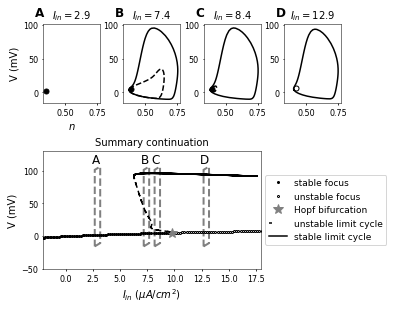

<Figure size 410.4x360 with 0 Axes>

In [27]:
#### Drawing phase planes relative to bif diagram
import string
from matplotlib.pylab import *

t_I_app_specf_temp_ii=[0,2,3,5]
t_I_app_specf_temp=np.array(t_I_app_specf)[t_I_app_specf_temp_ii]
n_splts=len(t_I_app_specf_temp)


plt.close("all")

n_splts=len(t_I_app_specf_temp)
size_axis_font=18
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.9))
        
ax=[]
for ii_iapi in range(len(t_I_app_specf_temp[::int(len(t_I_app_specf_temp)/n_splts)])):
    if ii_iapi>0:
        ax.append(plt.subplot2grid((62,4*(n_splts)), (0, ii_iapi*4), colspan=3,rowspan=20,sharex=ax[0],sharey=ax[0]))
    else:
        ax.append(plt.subplot2grid((62,4*(n_splts)), (0, ii_iapi*4), colspan=3,rowspan=20))


## Summary continuation..
axpl = plt.subplot2grid((62,4*(n_splts)), (32, 0), colspan=11,rowspan=34)

resol_cont=20
axpl.plot(m_res_par[0][m_res_par[0]<r1_fwd.getLabel('HB')[0][strIapp]][::resol_cont],m_res_statev[v_s_var=='v'][m_res_par[0]<r1_fwd.getLabel('HB')[0][strIapp]][::resol_cont],'o',markersize=2,color='k',label='stable focus',rasterized=True)
axpl.plot(m_res_par[0][m_res_par[0]>r1_fwd.getLabel('HB')[0][strIapp]][::resol_cont],m_res_statev[v_s_var=='v'][m_res_par[0]>r1_fwd.getLabel('HB')[0][strIapp]][::resol_cont],'o',markersize=2,color='k',mfc='none',label='unstable focus',rasterized=True)
axpl.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'*',markersize=10,color='grey',label='Hopf bifurcation')
usi=[(m_res_statev_lc[v_s_var=='v']<r1_period0.getLabel('LP')[0]['MAX v'])*(m_res_par_lc[0]<r1_fwd.getLabel('HB')[0][strIapp])]
axpl.plot(m_res_par_lc[0][usi][::resol_cont*4],m_res_statev_lc[v_s_var=='v'][usi][::resol_cont*4],'--', dashes=(2, 10),color='k',label='unstable limit cycle',rasterized=True)
axpl.plot(m_res_par_lc[0][m_res_statev_lc[v_s_var=='v']>r1_period0.getLabel('LP')[0]['MAX v']],m_res_statev_lc[v_s_var=='v'][m_res_statev_lc[v_s_var=='v']>r1_period0.getLabel('LP')[0]['MAX v']],color='k',label='stable limit cycle',rasterized=True)




axpl.set_xlabel(r'$I_{in}$ $(\mu A/cm^2)$')
axpl.set_ylabel('V (mV)')
axpl.set_title('Summary continuation')
axpl.set_xlim(t_I_app_specf_temp[0]-5,t_I_app_specf_temp[-1]+5)
axpl.set_ylim(-50,130)
axpl.legend(loc='center left', bbox_to_anchor=(1, 0.5))


s_x=0;s_y=1

###### Phase planes
v_saddle=[]
v_stable=[]
v_st_limit_cycle=[]
v_uns_limit_cycle=[]
v_st_tau_lc=[]
v_uns_tau_lc=[]
v_eig_focus=[]
for ii_iapi_ax,ii_iapi in enumerate(t_I_app_specf_temp_ii):
    saddle=[]
    stable=[]
    st_limit_cycle=[]
    uns_limit_cycle=[]
    st_tau_lc=[]
    uns_tau_lc=[]
    eig_focus=[]
    ### Plot limit cycle onset
    ax[ii_iapi_ax].set_title(r'$I_{in}'+' = '+ str(float("{0:.1f}".format(t_I_app_specf[ii_iapi])))+'$')
    st_lc=[]
    us_lc=[]
    for ii_api_lc in range(len(v_I_app)):
        if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<1*10**-5:
            unst_lc=0            
            try:
                if v_stab_lc[ii_api_lc]==0 and len(us_lc)==0: 
                    ax[ii_iapi_ax].plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],'--',color='black')
                    uns_limit_cycle=v_one_sim[ii_api_lc]
                    uns_tau_lc=v_tau_lc[ii_api_lc]
                    uns_floquet=v_floquet_mult[ii_api_lc]
                    us_lc.append(ii_api_lc)
                    print('unstable limit cycle')
                    print(str(t_I_app_specf[ii_iapi]))
                elif v_stab_lc[ii_api_lc]==1 and len(st_lc)==0:
                    ax[ii_iapi_ax].plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],color='black')
                    st_limit_cycle=v_one_sim[ii_api_lc]
                    st_tau_lc=v_tau_lc[ii_api_lc]
                    st_floquet=v_floquet_mult[ii_api_lc]
                    st_lc.append(ii_api_lc)
                    print('stable limit cycle')
                    print(str(t_I_app_specf[ii_iapi]))
            except:
                pass
    ### Plot ss
    for ii_api_ss in range(len(v_I_app_ss)):
        if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<0.1:
            if any(v_Jeival[ii_api_ss].real>0):
                ax[ii_iapi_ax].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=5,mfc='none',color='black')
                saddle=v_saddle_point[ii_api_ss]
            else:
                ax[ii_iapi_ax].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=5,color='black')
                stable=v_saddle_point[ii_api_ss]
                eig_focus=v_Jeival[ii_api_ss]
                
    axpl.text(t_I_app_specf[ii_iapi]+0.25,max(v_one_sim[ii_api_lc][0])+33,string.ascii_uppercase[ii_iapi_ax],{'fontsize':matplotlib.rcParams["font.size"]}, va="top", ha="right")

ax[0].set_xlabel('$n$')
ax[0].set_ylabel('V (mV)')


    
for ii_iapi_ax,ii_iapi in enumerate(t_I_app_specf_temp_ii):
    yaxses=ax[ii_iapi_ax].get_ylim()
    zoomingPoly(axpl, np.array([t_I_app_specf[ii_iapi]-0.25,t_I_app_specf[ii_iapi]+0.25,yaxses[0],yaxses[1]]), ax[ii_iapi_ax],dy=5,color='grey')

    
for n, axs in enumerate(ax):   
    axs.text(-0.15, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    
    
    
fig_name='fig_SummaryContinuation_'+model_name

md_dir={}
md_dir['Title']='Summary continuation Iin for '+model_name+' and pase planes for applied current '+str(t_I_app_specf_temp)
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(fig01,'./Figs/'+fig_name,md_dir,raster=300)

plt.show()

In [29]:
### run some simulations to find how the initial conditions don't determine the steady state
import sympy, scipy, brian2, matplotlib, brianutils
from brianutils import units
dir_sims_ISI='/groups/susanne/Data_Simulations/stochastic_bursting/'


sigma_v=[0.0,0,0,0]
v_vini=[-40.0,-40.0,80.0,80.0,20.0,7.073]
n_nini=[0.25,0.8,0.25,0.8,0.5,0.425]

num_neurons=len(v_vini) ## number of initial conditions to check out..

for ii_iapi in range(len(t_I_app_specf)):
    I_app=t_I_app_specf[ii_iapi]
    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
    if os.path.isfile(dir_sims_ISI+name+'.pkl'):
        print(':) File: '+name+' '+str(ii_iapi)+'/'+str(len(t_I_app_specf)))
    else:
        print('calculating: '+name+' ')
        M= json.load(open("cfg/"+model_name+".json"))
        M['parameters'].update(bifpar)
        M['parameters'][strIapp]=M['parameters'][strIapp][0]
        M["definitions"][strIapp] = "("+strIapp+"i - sig*xi)"
        M["parameters"].pop(strIapp)
        M["parameters"][strIapp+"i"]=str(I_app)+"* uA/cm2"
        M["parameters"]["sig"]=str(sigma_v[0])+"*(uA/cm2*(ms)**.5)"
        sde0= brianutils.load_model(M)
        brian2.defaultclock.dt=eval("0.001 * ms", units)
        neurons= brian2.NeuronGroup(num_neurons, model=sde0, method="heun",
            threshold="v>-10*mV", refractory="2.5*ms", namespace=units)
        ## INIT STATES ##
        for k in sde0.diff_eq_names:
            if k is not "v":
                setattr(neurons,k,0.25)

        vu= eval("1*mV",units)
        neurons.v=np.array(v_vini)*vu
        neurons.n=np.array(n_nini)
        spikes = brian2.SpikeMonitor(neurons)
        states=brian2.StateMonitor(neurons,sde0.diff_eq_names,record=True,dt=eval("0.01*ms",units))
        networkx= brian2.Network( neurons, spikes,states) # , states
        #### Running simulation in brian
        networkx.run(eval("5*second",units))
        #### storing simulation results in matrix and saving
        s_results=[]
        v_results=[]
        for k in v_one_sim_s[0]:
            s_results.append(k)
            if k is not "v":
                v_results.append(getattr(states,k))
            else:
                v_results.append(getattr(states,k)/brian2.mV)
                
        s_results.append('t')
        v_results.append(getattr(states,'t')/brian2.ms)
        v_results=np.array(v_results)
        spikes_a=[]   
        for inneurons in range(num_neurons):
            spikes_t=spikes.t[spikes.i==inneurons]/brian2.ms
            spikes_a.append(spikes_t)


        #### Saving simulation
        d_save_sim={}
        d_save_sim['s_results']=s_results
        d_save_sim['v_results']=v_results
        d_save_sim['spikes']=spikes_a
        d_save_sim['Dyn_Sys_Properties']={}
        d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']=v_st_limit_cycle[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']=v_uns_limit_cycle[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']=v_st_tau_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']=v_uns_tau_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['stable_floquetMult_lc']=v_st_FloquetMult_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['unstable_floquetMult_lc']=v_uns_FloquetMult_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['saddle']=v_saddle[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['stable']=v_stable[ii_iapi]
        d_save_sim['pars']=M["parameters"]
        save_obj(d_save_sim, dir_sims_ISI+name)
        print('Done with'+str(ii_iapi)+'/'+str(len(t_I_app_specf)))

:) File: SIM_Hodgkin_Huxley_I_in_2.9216854943_sigma_0.0 0/6
:) File: SIM_Hodgkin_Huxley_I_in_6.9216854943_sigma_0.0 1/6
:) File: SIM_Hodgkin_Huxley_I_in_7.4216854943_sigma_0.0 2/6
:) File: SIM_Hodgkin_Huxley_I_in_8.4216854943_sigma_0.0 3/6
:) File: SIM_Hodgkin_Huxley_I_in_8.9216854943_sigma_0.0 4/6
:) File: SIM_Hodgkin_Huxley_I_in_12.9216854943_sigma_0.0 5/6


In [30]:
#### This is the format for the figures in the thesis
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

mean ISI 2.5047210992315403
6.9216854943


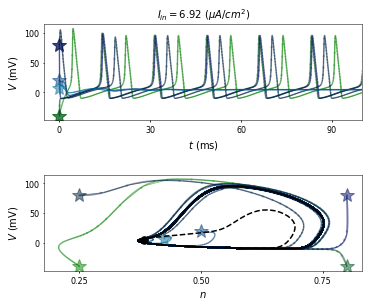

<Figure size 410.4x360 with 0 Axes>

In [31]:
from matplotlib.pylab import *



ii_iapi=1
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))

for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
# ax.set_ylabel('$'+v_one_sim_s[0][idx_v]+'$ (mV)')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)

print('mean ISI '+str(np.mean(np.concatenate(v_ISI))))
print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig01.show()

mean ISI 2.504288708869216
8.4216854943


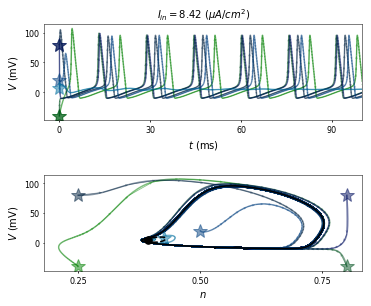

<Figure size 410.4x360 with 0 Axes>

In [32]:
from matplotlib.pylab import *


ii_iapi=3
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)

print('mean ISI '+str(np.mean(np.concatenate(v_ISI))))
print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

fig01.show()

mean ISI 2.5019182447651622
8.9216854943


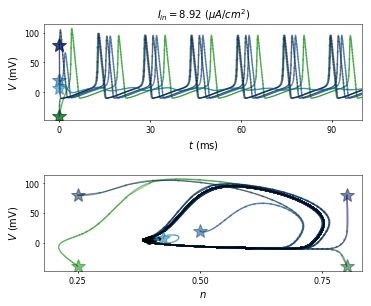

<Figure size 410.4x360 with 0 Axes>

In [33]:
from matplotlib.pylab import *


ii_iapi=4
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)

print('mean ISI '+str(np.mean(np.concatenate(v_ISI))))
print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(fig01,'./Figs/'+fig_name,md_dir,raster=300,tight=True)
# fig01.savefig('./Figs/'+fig_name+'.svg', format="svg")
fig01.show()

mean ISI 2.500049945801718
2.9216854943


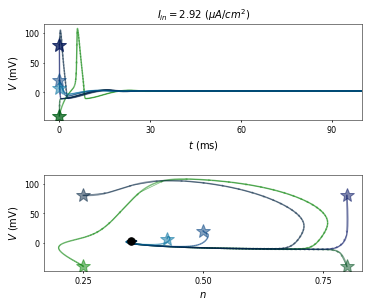

<Figure size 410.4x360 with 0 Axes>

In [34]:
from matplotlib.pylab import *


ii_iapi=0
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)

print('mean ISI '+str(np.mean(np.concatenate(v_ISI))))
print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(fig01,'./Figs/'+fig_name,md_dir,raster=300,tight=True)
fig01.show()

mean ISI 2.5
12.9216854943


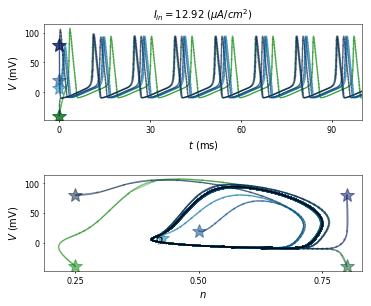

<Figure size 410.4x360 with 0 Axes>

In [35]:
from matplotlib.pylab import *


ii_iapi=5
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)

print('mean ISI '+str(np.mean(np.concatenate(v_ISI))))
print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

fig01.show()

mean ISI 2.500049945801718
2.9216854943


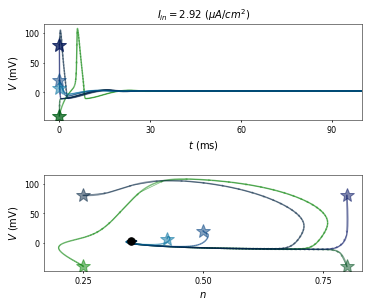

<Figure size 410.4x360 with 0 Axes>

In [39]:
from matplotlib.pylab import *


ii_iapi=0
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)

print('mean ISI '+str(np.mean(np.concatenate(v_ISI))))
print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig01.show()

unstable limit cycle
8.4216854943
stable limit cycle
8.4216854943


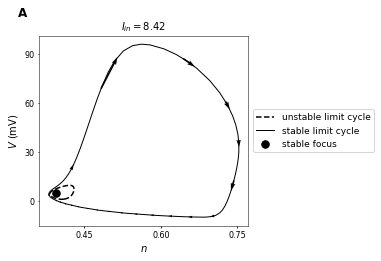

<Figure size 410.4x360 with 0 Axes>

In [37]:
#### Drawing phase planes relative to bif diagram

plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.7))
ax0 = plt.subplot2grid((5,6), (0, 0), colspan=4,rowspan=5)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_iapi=3

saddle=[]
stable=[]
st_limit_cycle=[]
uns_limit_cycle=[]
st_tau_lc=[]
uns_tau_lc=[]
### Plot limit cycle onset

st_lc=[]
us_lc=[]
for ii_api_lc in range(len(v_I_app)):
    if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<1*10**-5:
        try:
            if v_stab_lc[ii_api_lc]==0 and len(us_lc)==0: 
                ax0.plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],'--',label='unstable limit cycle',color='black')
                uns_limit_cycle=v_one_sim[ii_api_lc]
                uns_tau_lc=v_tau_lc[ii_api_lc]
                us_lc.append(ii_api_lc)
                print('unstable limit cycle')
                print(str(t_I_app_specf[ii_iapi]))
            elif v_stab_lc[ii_api_lc]==1 and len(st_lc)==0:
                ax0.plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],linewidth=1,label='stable limit cycle',color='black')
                st_limit_cycle=v_one_sim[ii_api_lc]
                st_tau_lc=v_tau_lc[ii_api_lc]
                st_lc.append(ii_api_lc)
                print('stable limit cycle')
                print(str(t_I_app_specf[ii_iapi]))
        except:
            pass

### Plot ss
for ii_api_ss in range(len(v_I_app_ss)):
    if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<0.01:
        if any(v_Jeival[ii_api_ss].real>0):
            ax0.plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=7.5,mfc='none',color='black',label='unstable focus')
            saddle=v_saddle_point[ii_api_ss]
        else:
            ax0.plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=7.5,color='black',label='stable focus')
            stable=v_saddle_point[ii_api_ss]

ax0.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')

ax0.set_ylabel('$V$ (mV)')
ax0.set_title(r'$I_{in}'+' = '+ str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$')

I_app=t_I_app_specf[ii_iapi]
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']

ii=0

st=3500
nd=4500
nv=v_results[idx_nk][ii][st:nd:10][:-1]
vv=v_results[idx_v][ii][st:nd:10][:-1]
dn=v_results[idx_nk][ii][st:nd:10][1:]-v_results[idx_nk][ii][st:nd:10][:-1]
dv=v_results[idx_v][ii][st:nd:10][1:]-v_results[idx_v][ii][st:nd:10][:-1]

ax0.quiver(nv[::5], vv[::5], dn[::5], dv[::5],color='k', scale_units='xy', angles='xy', scale=1.0, rasterized=True)
ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5))

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax0.xaxis.set_major_locator(locatory2)

ax0.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax0.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')

fig_name='fig_Bistable_subHopf_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(fig01,'./Figs/'+fig_name,md_dir,raster=300)
# fig01.savefig('./Figs/'+fig_name+'.svg', format="svg")
fig01.show()

unstable limit cycle
8.4216854943
stable limit cycle
8.4216854943


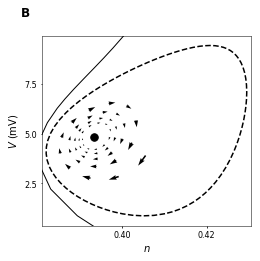

<Figure size 410.4x360 with 0 Axes>

In [38]:
#### Drawing phase planes relative to bif diagram

plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.7))
ax0 = plt.subplot2grid((5,6), (0, 0), colspan=4,rowspan=5)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n'][0]

ii_iapi=3

saddle=[]
stable=[]
st_limit_cycle=[]
uns_limit_cycle=[]
st_tau_lc=[]
uns_tau_lc=[]
### Plot limit cycle onset

st_lc=[]
us_lc=[]
for ii_api_lc in range(len(v_I_app)):
    if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<1*10**-5:
        try:
            if v_stab_lc[ii_api_lc]==0 and len(us_lc)==0: 
                ax0.plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],'--',color='black')
                uns_limit_cycle=v_one_sim[ii_api_lc]
                uns_tau_lc=v_tau_lc[ii_api_lc]
                us_lc.append(ii_api_lc)
                print('unstable limit cycle')
                print(str(t_I_app_specf[ii_iapi]))
            elif v_stab_lc[ii_api_lc]==1 and len(st_lc)==0:
                ax0.plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],linewidth=1,color='black')
                st_limit_cycle=v_one_sim[ii_api_lc]
                st_tau_lc=v_tau_lc[ii_api_lc]
                st_lc.append(ii_api_lc)
                print('stable limit cycle')
                print(str(t_I_app_specf[ii_iapi]))
        except:
            pass

### Plot ss
for ii_api_ss in range(len(v_I_app_ss)):
    if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<0.01:
        if any(v_Jeival[ii_api_ss].real>0):
            ax0.plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=7.5,mfc='none',color='black')
            saddle=v_saddle_point[ii_api_ss]
        else:
            ax0.plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=7.5,color='black')
            stable=v_saddle_point[ii_api_ss]

ax0.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')

ax0.set_ylabel('$V$ (mV)')


I_app=t_I_app_specf[ii_iapi]
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']

ii=5

# st=4500
st=1500
nd=6500
nv=v_results[idx_nk][ii][st:nd:10][:-1]
vv=v_results[idx_v][ii][st:nd:10][:-1]
dn=v_results[idx_nk][ii][st:nd:10][1:]-v_results[idx_nk][ii][st:nd:10][:-1]
dv=v_results[idx_v][ii][st:nd:10][1:]-v_results[idx_v][ii][st:nd:10][:-1]

ax0.quiver(nv[::10], vv[::10], dn[::10], dv[::10],color='k', scale_units='xy', angles='xy', scale=0.3, rasterized=True)

ax0.set_xlim([min(uns_limit_cycle[1])-0.001,max(uns_limit_cycle[1])+0.001])
ax0.set_ylim([min(uns_limit_cycle[0])-0.5,max(uns_limit_cycle[0])+0.5])

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax0.xaxis.set_major_locator(locatory2)

ax0.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax0.transAxes, 
        size=matplotlib.rcParams["font.size"], weight='bold')


fig_name='fig_zoomInto_Bistable_subHopf_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig01.show()